### LT2326 HT21 Project
##### Calvin Kullvén Liao


#### Part 01 Dataset and preprocessing

In [1]:
import pandas as pd

In [2]:
# The original dataset are very large which takes long to process, so I only sample a small part
pos_comments = pd.read_csv('data/comments_positive.csv').sample(2000)
neg_comments = pd.read_csv('data/comments_negative.csv').sample(2000)

It appears that the upvotes/downvotes are concentrated, with extremely high/low score being a rarity. But upvotes have a wider range (with scores under 500 being more common) than downvotes (scores below -100 are rare).

One way to preprocess this may be excluding the very high/low scores and only keep the ones within the common score range. Or see it as a pos vs neg binary classification.

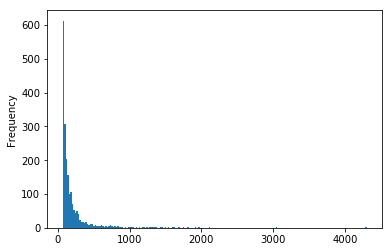

In [4]:
pos_comments['score'].plot.hist(bins=200)

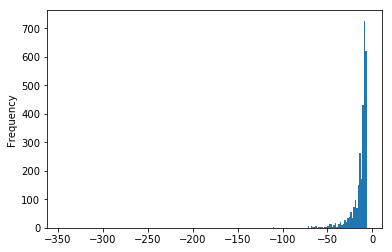

In [4]:
neg_comments['score'].plot.hist(bins=200)

In [5]:
# Simple binary classes instead of the plus/minus scores
pos_comments['polarity'] = 1
neg_comments['polarity'] = 0

# Normalize the scores to 0~1 or 0~-1
pos_comments['score'] = pos_comments['score'].transform(lambda x: x / abs(x).max())
neg_comments['score'] = neg_comments['score'].transform(lambda x: x / abs(x).max())

pos_comments['parent_score'] = pos_comments['parent_score'].transform(lambda x: x / abs(x).max())
neg_comments['parent_score'] = neg_comments['parent_score'].transform(lambda x: x / abs(x).max())

In [6]:
comments = pd.concat([pos_comments, neg_comments])

# There are duplicate columns, eg, 'ups' and 'score' are the same thing.
repeated = ['ups', 'parent_ups']
# Also dropping non-relevant columns
others = ['id', 'parent_id', 'subreddit_id', 'link_id', 'author', 'parent_link_id', 
          'parent_author', 'controversiality', 'parent_controversiality']
drop_these = lambda df:df.drop(columns=repeated+others) 

# Some texts are non-strings, or are only URLs
filter_str = lambda df:df[df['text'].apply(lambda x: isinstance(x, str))]
exclude_jpg = lambda df:df[~df['text'].str.contains("https://")]
                      
comments = exclude_jpg(filter_str(drop_these(comments)))
comments.sample(5)

,text,score,parent_text,parent_score,polarity
379362,I DONT give a shit about my Grammar,-0.078947,It COULD *have* been.,0.016399,0
1630136,Anyone who makes blanket statements about who ...,-0.030702,Anyone who doesn't vaccinate their child is an...,0.020044,0
1685952,I can think of better ways of showing them off...,-0.030702,That guy has really nice legs. I say if you go...,0.002915,0
1276304,"The message is clear, if you buy DVDs, you are...",0.022078,Also the people with the DVD are sitting in a ...,0.068229,1
477032,"Yup, from a quick search\n\n""It is not an acci...",-0.070175,OMG you must be an anti-Semite!,0.043003,0


#### Build the tokek-to-integer mapping

In [7]:
# from string import punctuation
# from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english')) 

def clean_text(text, lemmatize=False , clean_punc=False, clean_stopwords=False):
    
    text = str(text) # in case of non-string values
    text = text.lower()
    text = TweetTokenizer().tokenize(text) # => list of tokens
    
    if lemmatize:
        text = [WordNetLemmatizer().lemmatize(token) for token in text]

    if clean_punc:
        text = [token for token in text if token not in punctuation]
    if clean_stopwords:
        text = [token for token in text if token not in stop_words]
    
    return text

def df_to_generator(df):
    df = df.dropna()
    for i, row in df.iterrows():
        columns = row.to_list() # text, score, parenttext, parentscore, polarity
        yield columns
        
comments_iter = df_to_generator(comments)

In [8]:
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(comments_iter):
    for text, _, parenttext, _, _ in comments_iter: # text, score, parenttext, parentscore, polarity
        yield clean_text(text)+clean_text(parenttext)

vocab = build_vocab_from_iterator(yield_tokens(comments_iter), specials=["<pad>"])
vocab.set_default_index(vocab["<pad>"])

#### Shuffle and split to train/test

In [9]:
# Shuffle and split to train/test
from sklearn.model_selection import train_test_split
train_comments, test_comments = train_test_split(comments, test_size=0.2)

#### Turn the text into arrays

In [10]:
import numpy as np
text_to_ids = lambda text: vocab(clean_text(text))
text_to_array = lambda text: np.array(text_to_ids(text))

In [11]:
train_comments['text'] = train_comments['text'].apply(text_to_array)
train_comments['parent_text'] = train_comments['parent_text'].apply(text_to_array)
test_comments['text'] = test_comments['text'].apply(text_to_array)
test_comments['parent_text'] = test_comments['parent_text'].apply(text_to_array)

train_comments

/tmp/ipykernel_1108758/1422472211.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_comments['text'] = train_comments['text'].apply(text_to_array)
/tmp/ipykernel_1108758/1422472211.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_comments['parent_text'] = train_comments['parent_text'].apply(text_to_array)
/tmp/ipykernel_1108758/1422472211.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


,text,score,parent_text,parent_score,polarity
1483559,"[7, 153, 13084, 10, 150, 405, 55, 8, 139, 1277...",-0.035088,"[58, 9247, 10, 28, 76, 1277, 3120, 1541, 13, 2...",0.005466,0
1446222,"[53, 53, 3, 140, 9, 1]",-0.035088,"[14, 2776, 16073, 16262, 14, 312, 3, 140, 9, 1]",0.004373,0
1184821,"[121, 40, 924, 20, 4, 311, 62, 143, 441, 311, ...",-0.039474,"[328, 20, 1310, 3, 328, 32, 6612, 1, 54, 46, 3...",0.036079,0
322484,"[53, 12, 14502, 39, 11854]",-0.087719,"[7, 71, 12, 19, 18307, 227]",0.005831,0
770506,"[7, 51, 403, 16, 47, 549, 8, 146, 4, 97, 12, 1...",0.033233,"[270, 403, 1632, 4, 406, 17, 501, 282, 1]",0.023435,1
...,...,...,...,...,...
1360630,"[2914, 247, 7, 1272, 10, 522]",-0.035088,"[2, 4290, 234, 10, 9, 288, 12, 10, 1421, 39, 9...",0.295190,0
11974,"[1143, 25, 18747, 75, 3085, 1]",0.379503,"[269, 30, 86, 1272, 696, 1]",0.134233,1
501983,"[7, 59, 284, 4280, 77, 253, 12170, 6, 19215, 1...",-0.065789,"[15446, 15, 44, 103, 28, 2742, 3751, 50, 430, ...",0.005831,0
1191484,"[7, 78, 26, 12, 220, 67, 178, 2588, 93, 28, 12...",0.023472,"[32, 346, 42, 2, 14, 2909, 4438, 14, 4485, 51,...",0.014684,1


#### Turn the dataframe rows into a list of tuples so they can be batch-loaded

In [12]:
def getXY(df):
    XY = []
    for i, row in df.iterrows():
        text, score, parenttext, parentscore, polarity = row.to_list() 
        XY.append((text, score, polarity))
    return XY
        
trainXY = getXY(train_comments)
testXY = getXY(test_comments)

#### Model

In [139]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class UpDownPredictor(nn.Module):
    def __init__(self, vocabsize, device, embed_size=300, hidden_size=128):
        super(UpDownPredictor, self).__init__()
        
        self.device = device
        self.embed = nn.Embedding(vocabsize, embed_size, padding_idx=0) # vocab => embsize
        
        self.lstm = nn.LSTM(embed_size, hidden_size, dropout = 0.2, num_layers = 2,
                           batch_first=True, bidirectional=True) # embsize => hidsize
        
        self.drop = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
#         self.fc = nn.Linear(2*hidden_size, 64) # 2xhidsize => 64
        self.classify2 = nn.Linear(2*hidden_size, 2)
        
    def forward(self, x, xlen):
        
        embedded = self.embed(x) 
        
        packed = pack_padded_sequence(embedded, xlen, batch_first=True, enforce_sorted=False)
        packedout, _ = self.lstm(packed)
        output, _ = pad_packed_sequence(packedout, batch_first=True)
        

#         output = self.fc(output) # B,256 => B,64
        output = self.maxpool(output)
        output = self.relu(output)
#         output = self.sig(output)
        
        output = self.drop(output)
        output = self.relu(output)
        output = self.classify2(output)
        
        return output

    def classify(self, tensor): # flatten (Token x Hidden) and linearize to 2
        if len(tensor.shape)==3:
            B,N,H = tensor.shape
        elif len(tensor.shape)==2:
            B,N = tensor.shape
            H = 1
        tensor = tensor.reshape(B, N*H)
        lin = nn.Linear(N*H, 2).to(self.device)
        tensor = lin(tensor)
        return tensor
    
    def maxpool(self, tensor, dim=1):
        indices = torch.argmax(tensor, dim)
        output_tensor = torch.gather(tensor, dim, index=indices.unsqueeze(dim)).squeeze(dim)
        return output_tensor

#### Train and eval in each epoch

In [37]:
def get_accu_and_f1(collect_preds, collect_golds):
    allpreds, allgolds = torch.cat(collect_preds).float(), torch.cat(collect_golds).float()

    tp = sum(allgolds * allpreds)
    fp = sum(allgolds * (~allpreds.bool()).float())
    tn = sum((~allgolds.bool()).float() * (~allpreds.bool()).float())
    fn = sum((~allgolds.bool()).float() * allpreds)

    accuracy = (tp + tn) / (tp + fp + tn + fn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1 = (2 * recall * precision) / (recall + precision)
    
    return accuracy, f1

import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim

def collate_batch(batch):
    texts, scores, labels, lengths = [], [], [], []
#     offsets = [0]
    for text, score, label in batch:
        labels.append(label)
        scores.append(score)
        lengths.append(len(text))
        text_tensor = torch.tensor(text, dtype=torch.int64)
        texts.append(text_tensor)
#         offsets.append(text_tensor.size(0))
        
    labels = torch.tensor(labels, dtype=torch.int64)
    scores = torch.tensor(scores)
    lengths = torch.tensor(lengths)
#     offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    
    #pad to max len
    texts = pad_sequence(texts, batch_first=True, padding_value=0)
    return texts, scores, labels, lengths #, offsets


# train => eval and save => plot accu/f1
def train(model, epochs, trainXY, testXY, model_fn, device, save_every=0, batch_size=100, lr=0.005):
    
    # Train/test batches
    train_batches = DataLoader(trainXY, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
    test_batches = DataLoader(testXY, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
    
    # Models
    model.to(device)
    
    # Loss funcs & optimizers
    loss_fn = nn.CrossEntropyLoss(ignore_index=-1) # ignore sentence padding
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    
    # Each epoch: train models -> eval models, get accuracy and f1
    all_accu, all_f1, all_losses, all_test_losses = [],[],[],[]
    for e in range(epochs):
        
        # TRAIN
        model.train()
        total_loss = 0
        for i, (x, _, y, xlen) in enumerate(train_batches):
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            
            out = model(x, xlen) 
            targets = y
            
            loss = loss_fn(out, targets) 
            total_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
            print(f"Training epoch {e+1}: AvgLoss {total_loss/(i+1)}", end='\r')
        
        all_losses.append(total_loss) # total loss of current epoch
        
        if save_every!=0 and (e+1)%save_every==0:
            torch.save(model, model_fn+f"_epoch_{e+1}") # save every n-th trained model 
        
        # EVAL & TEST
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            
            collect_preds = []
            collect_golds = []
            
            for i, (x, _, y, xlen,) in enumerate(test_batches):
                x, y = x.to(device), y.to(device)
                
                # Model predictions 
                preds = model(x, xlen)
                
                binary_preds = preds.argmax(1)
                targets = y
                
                collect_preds.append(binary_preds) 
                collect_golds.append(targets)
                
                
                loss = loss_fn(preds, targets) 
                total_test_loss += loss.item()
                
                print(f"Evaluating epoch {e+1}: AvgLoss {total_test_loss/(i+1)}", end='\r')
                    
        all_test_losses.append(total_test_loss) # total test loss of current epoch
        
        # Compare predictions of models with golds
        accuracy, f1 = get_accu_and_f1(collect_preds, collect_golds)
        # Result of current epoch
        all_accu.append(accuracy.item())
        all_f1.append(f1.item())
        
    torch.save(model, model_fn+f"_epoch_{e+1}") # save final trained model
    stats = (all_losses, all_test_losses, all_accu, all_f1)

    return model, stats

In [140]:
device = 'cuda:3'
model_init = UpDownPredictor(len(vocab),device)

model, stats = train(model_init, 50, trainXY, testXY, 'predictorModel', device)

#### TO LOAD TRAINED MODEL

In [111]:

model = torch.load('predictorModel_epoch_50').to('cpu')
model.eval()

UpDownPredictor(
  (embed): Embedding(21203, 300, padding_idx=0)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (drop): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (sig): Sigmoid()
  (classify2): Linear(in_features=256, out_features=2, bias=True)
)

#### Evaluating performance

In [43]:
import matplotlib.pyplot as plt

def plot_line_chart(stats):
    # Draw the line chart
    n_epochs = len(stats[0])
    the_epochs = list(range(1,n_epochs+1))    

    # lines
    train_loss, test_loss, accu, f1 = stats
    
    for i in range(2):
        if i==0:
            plt.plot(the_epochs, train_loss, label='training loss')
            plt.plot(the_epochs, test_loss, label='testing loss')
            
            plt.title('Losses over iterations')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
        else:
            plt.plot(the_epochs, accu, label='accuracy')
            plt.plot(the_epochs, f1, label='f1')

            plt.title('Accuracy/F1 over iterations')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

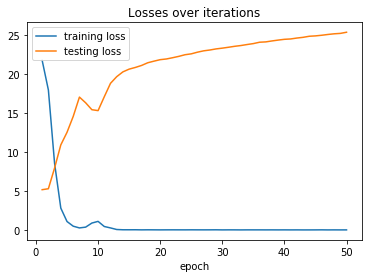

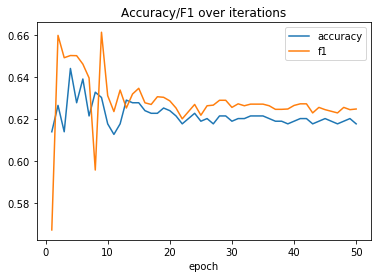

In [144]:
plot_line_chart(stats)

In [176]:
def get_model_inputs(text):
    test_tensor = torch.tensor(text_to_array(text)).unsqueeze(0).to('cuda:3')
    text_len = torch.tensor(test_tensor.shape[1], dtype=torch.int64).unsqueeze(0)
    return test_tensor, text_len
    
testtext = "this is a machine learning model that is trying predicting popularity!"

get_model_inputs(testtext)

(tensor([[  17,   11,    5, 1330, 1226, 1773,   10,   11,  218,    0, 6603,   44]],
        device='cuda:3'),
 tensor([12]))

In [174]:
model.to('cuda:3')
model.eval()
with torch.no_grad():
    out = model( *get_model_inputs('how much wood would a woodchuck chuck if a woodchuck would chuck wood?') )
    print(out.argmax(1))

tensor([1], device='cuda:3')
